This is my first notebook in quite a while, did some full-stack work as well as develop applications for a company. That has taken the majority of my time, I haven't been able to get back into machine learning for a little bit, hopefully some of my knowledge is still there, always excited to re-learn it, as the pathways are there, they just need to be refreshed.

Some things I've been up to:

- I started a new repo, one of my top full-stack applications, I called it buckles chat, after my pet cat.
  - https://github.com/cthacker-udel/BucklesChat
  - https://github.com/cthacker-udel/BucklesChatService
    - This was a very ambitious project, was a lot to take on, involved making an attempt at discord from scratch, using one of my most favorite frameworks [NextJS](https://nextjs.org/), and express for the backend. It was a lot to take on admittedly, I had to integrate 3 different databases into the application (Postgresql, MongoDB, Redis) and also integrate them all in nodejs without any hiccups. I had to finally tackle my avoidance of json web tokens, and it turned out to be extremely easy to implement, along with a full-fledged session library as well. This involved implementing complex middleware manually into the application. I used redis for managing user online status and also managing login throttling logic (which was fun to implement from scratch). This caused lots of time being devoted to developing because making this application was a blast. I had a moment where I completely refactored the structure of my database, involving switching all the foreign keys, and multiple column types as well. I used `sequelize` to handle all the postgres query generation, as doing that manually was difficult along with tedious when I could utilize an ORM to achieve the same functionality, those exist and are widely used (entity framework for example) I actually created a strong backend initially in C#, using ASP.Net core to achieve it, and it was working, but then I ran into the issue of figuring out how to deploy it, and that caused me to instantly transfer the entire backend to typescript using expressJS to handle all api functionality.
- Besides this project, I was moved from a project to head and complete an entire project on my own at work, without any assistance whatsoever, so that has been a challenge to complete and see it to the end. It involves RPA and C#, interesting work.

Besides all of that, let's get to our first notebook, processing HR competency scores used for screening.

## Dataset

Our dataset comprises of competency screening data for each candidate, which holds for example their years of experience, their top_1 skills score, their top2_behavior score, and whether they were called for an interview (most likely offered the job), this is actually something I can see being used in companies, and something that plays a role in lots of company's hiring processes.

In [35]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load in the dataset

hr_competency_screening_data = pd.read_csv('./dataset.csv')

hr_competency_screening_data.shape

# We have 300 rows to work with, so splitting will play a major factor in whether we over-train or under-train our model

(300, 10)

In [37]:
# Let's examine the columns datatypes

hr_competency_screening_data.dtypes

# It looks like we have majority float64 data type, and our target column is type integer

years_of_experience            float64
functional_competency_score    float64
top1_skills_score              float64
top2_skills_score              float64
top3_skills_score              float64
behavior_competency_score      float64
top1_behavior_skill_score      float64
top2_behavior_skill_score      float64
top3_behavior_skill_score      float64
call_for_interview               int64
dtype: object

In [38]:
# We can remove the target column and make a data tables of just the features (columns we are using to make the prediction)

target = hr_competency_screening_data['call_for_interview']

(target.head(), target.dtype)

# As you can see here, we got the correct column into the target variable, and the datatype matches up, int64.

(0    1
 1    0
 2    0
 3    0
 4    1
 Name: call_for_interview, dtype: int64,
 dtype('int64'))

In [39]:
# Now, let's compile the feature dataframe

potential_features = hr_competency_screening_data.drop(columns=['call_for_interview'])


(potential_features.columns, potential_features.shape)

# As you can see, having a shape of 300 rows and 9 columns means that we dropped the target column from the dataset

(Index(['years_of_experience', 'functional_competency_score',
        'top1_skills_score', 'top2_skills_score', 'top3_skills_score',
        'behavior_competency_score', 'top1_behavior_skill_score',
        'top2_behavior_skill_score', 'top3_behavior_skill_score'],
       dtype='object'),
 (300, 9))

Text(0.5, 0, 'Years of Experience')

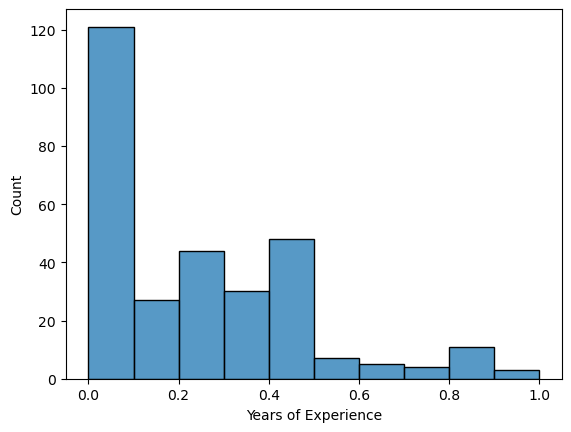

In [47]:
# Lets make a histogram of the frequency of years_of_experience

potential_features_axes = sns.histplot(potential_features['years_of_experience'], stat='count')

potential_features_axes.set_xlabel("Years of Experience")

As we can see from this chart, the majority of applicants don't even have close to half a year of experience, so that will be a major contributing factor into our predictions, also, there seems to be a major cutoff when the years of experience hit 0.5 (aka half a year), so maybe we could group all values >= 0.5 into one category to maybe balance out the proportions, let's try that out.

In [72]:
potential_features['expert_years_of_experience'] = potential_features['years_of_experience'].map(lambda x: x >= 0.5)

expert_years = potential_features[potential_features['expert_years_of_experience'] == True]
non_expert_years = potential_features[potential_features['expert_years_of_experience'] == False]

percentage_of_experts = (expert_years.shape[0] + non_expert_years.shape[0]) / expert_years.shape[0]

f'{percentage_of_experts}% of the applicants have more then half a year of experience'

'10.0% of the applicants have more then half a year of experience'

The fact that only 10% of applicants in this dataset have more then half a year of experience shows either a desirability, or a scarcity, as most of the people did not have the proper experience for the job. This paints an interesting picture in this small dataset. It is mostly comprised of people who did not have a lot of experience with the skills required for this job, and they applied anyway. As we dig more into this dataset, we can explore maybe how they managed when recruiting/deciding whether to hire people with more then half a year of relative experience. Let's graph the frequency of that small subset into another histogram.

<AxesSubplot:xlabel='years_of_experience', ylabel='Count'>

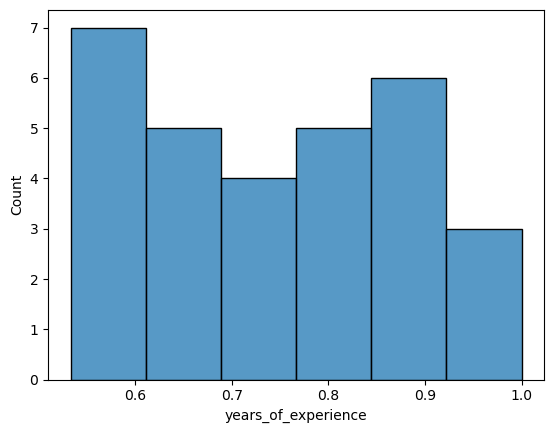

In [77]:
sns.histplot(expert_years['years_of_experience'], stat='count')

This histogram gives us a good idea of the count of each of the years of experience among the small 10% subset that has half or more of a year of experience. There seems to be barely any applicants that have a year of experience, only about 3 out of the 300 applicants had a full year of experience. This puts into perspective really how absurd the assumption is that everyone applying for a job has all the qualifications completely satisfied. The majority of applicants seem to have a range from 0.5 --> 0.69 and 0.76 --> 0.92. We can sate that the small dip in the graph is relatively a small part of the totality of the graph (only about 0.05 years)